In [20]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl
from numba import float32, float64, jit, NumbaPerformanceWarning
import warnings
import os

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

from utils import simulate_onestep_campi_example_1

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [21]:
from pathlib import Path
import time
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformer_onestep import GPTConfig, GPT
from dataset_simple_example_1 import SimpleExample1Dataset
import tqdm
import argparse
import metrics

In [22]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [23]:
# Fix all random sources to make script fully reproducible
torch.manual_seed(420)
np.random.seed(430)
system_seed = 430 # Controls the system generation
data_seed = 0 # Control the input generation

In [24]:
# Overall settings
out_dir = "out"

# System settings
nu = 1
ny = 1
#seq_len = 600
batch_size = 50 # 256

# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 10
compile = False

# Configure compute
torch.set_num_threads(threads) 
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [25]:
# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_controller_simple_example_1.pt", map_location=device)

In [26]:
seq_len = exp_data["cfg"].seq_len
nx = exp_data["cfg"].nx

In [27]:
model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 2.43M


In [28]:
test_ds = SimpleExample1Dataset(seq_len=seq_len, normalize=True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [29]:
# Prediction
batch_u, batch_e = next(iter(test_dl))
with torch.no_grad():
    batch_u_pred, loss = model(batch_e, batch_u)

In [30]:
print(batch_u_pred.shape)
print(batch_u.shape)

torch.Size([50, 500, 1])
torch.Size([50, 500, 1])


1


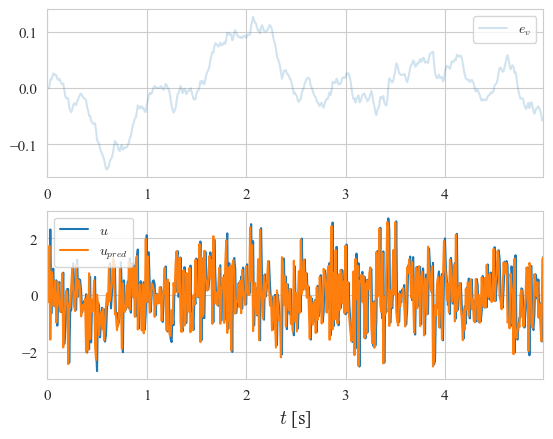

In [31]:
plt.figure()
#plt.plot(batch_input[0,:,0])
Ts = 1e-2
T = batch_e.shape[1]*Ts  # ts*self.seq_len# * 2
t = np.arange(0, T, Ts)

for i in range(1,2):
    print(i)
    plt.subplot(211)
    plt.plot(t, batch_e[i, :, 0], c='tab:blue', alpha=0.2)
    plt.legend(['$e_v$'])
    plt.subplot(212)
    plt.plot(t, batch_u[i, :, 0], c='tab:blue', alpha=1)
    plt.plot(t, batch_u_pred.detach().numpy()[i, :, 0], c='tab:orange', alpha=1)
    plt.legend(['$u$', '$u_{pred}$'])
    plt.xlabel("$t$ [s]")
plt.show()

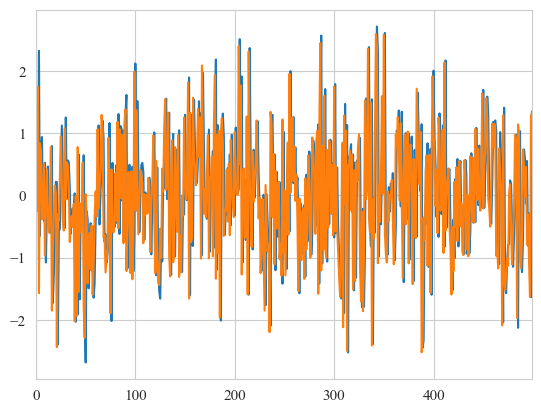

In [32]:
plt.plot(batch_u[1, :, 0])
plt.plot(batch_u_pred.detach().numpy()[1, :, 0])

 ORANGE IS PRACTICALLY EQUAL TO BLUE BUT ONE STEP BEHIND




In [33]:

batch_u_one_step_ahead = batch_u[:, 1:, :]

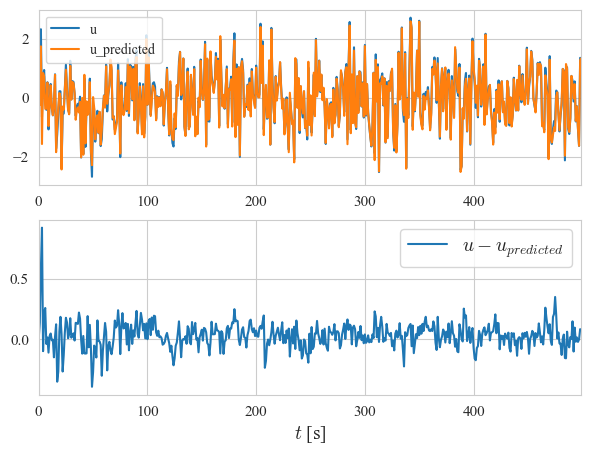

In [34]:
error1 = batch_u_one_step_ahead[1,:,0]- batch_u_pred.detach().numpy()[1, :-1, 0]

fig = plt.figure(figsize=(7, 5))

ax1 = plt.subplot(211)
plt.plot(batch_u_one_step_ahead[1,:,0])
plt.plot(batch_u_pred.detach().numpy()[1, :, 0])
plt.legend(['u','u_predicted'])

ax2 = plt.subplot(212, sharex=ax1)
plt.plot( error1, c='tab:blue', alpha=1)
plt.xlabel('$t$ [s]')
plt.legend(['$u - u_{predicted}$'], loc = 'upper right',prop={'size': 14})

# plt.savefig('transformer_controller.pdf')

plt.show()

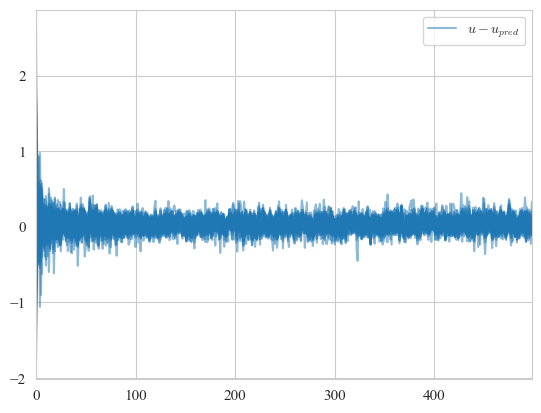

In [35]:
from sklearn.metrics import mean_squared_error
#error = batch_u_one_step_ahead[1,:,0]- batch_u_pred.detach().numpy()[1, :-1, 0]
error = batch_u_one_step_ahead[:,:,0]- batch_u_pred.detach().numpy()[:, :-1, 0]

for i in range(batch_size):
    plt.plot( error[i, :], c='tab:blue', alpha=0.5)
    plt.legend(['$u-u_{pred}$'])
plt.show()


In [36]:
#calculate medium error
medium_error = 0
for k in range(len(error[0])):
    for i in range(batch_size):
        medium_error = medium_error + np.abs(error[i,k])

medium_error = medium_error / (len(error[0]) * batch_size)
print(medium_error)


relative_error = 0
for i in range(batch_size) : 
    for k in range(len(error[i])):
        e_abs = np.abs(error[i,k])
        ref_abs = (np.abs(batch_u_one_step_ahead[i,k,0]))
        e_rel = e_abs / ref_abs
        if e_rel < 10 : 
            relative_error += e_rel
        


re = relative_error/ ( len(error[0]) * batch_size) * 100

print(f"Relative Error: {re:.2f}%")

tensor(0.0735)
Relative Error: 25.09%


PLOT DISTRIBUSTION OF THE SIGNALS

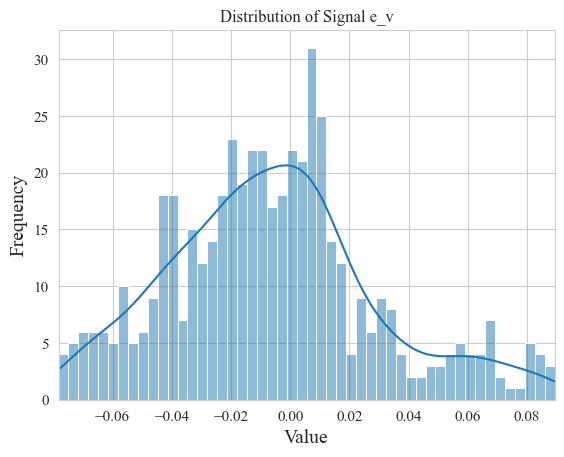

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example signal u
e = batch_e[i, :, 0]

# Plot histogram and KDE using Seaborn
sns.histplot(e, kde=True,bins = 50)
plt.title('Distribution of Signal e_v')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

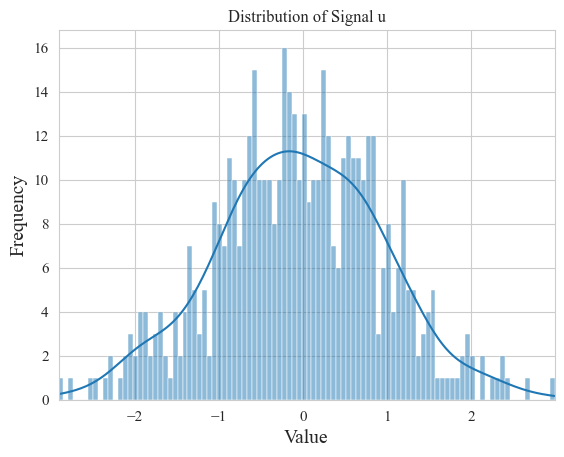

In [38]:
# Example signal u
u = batch_u_pred.detach().numpy()[i, :, 0]

# Plot histogram and KDE using Seaborn
sns.histplot(u, kde=True, bins = 100)
plt.title('Distribution of Signal u')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

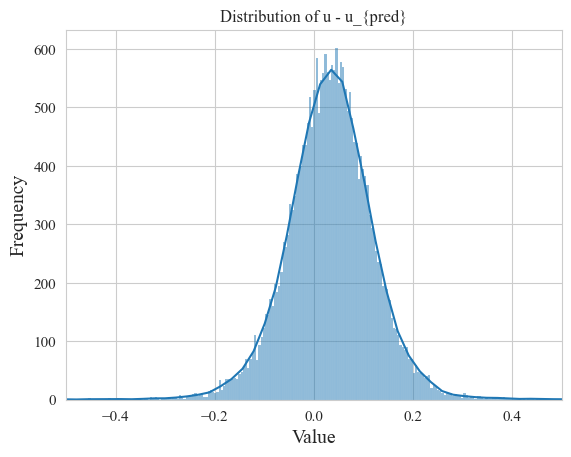

In [47]:
# Example signal u
ERROR = []

for i in range(batch_size):
    for j in range(len(error[0])) : 
        ERROR.append(error[i][j])

ERRORR = np.array(ERROR)


# Plot histogram and KDE using Seaborn
sns.histplot(ERRORR, kde=True, bins = 1000)
plt.title('Distribution of u - u_{pred}')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xlim(-0.5, 0.5)
plt.show()